In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [23]:
expers_to_load = [# Meta V1 model regressionT
                  (True, "run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05"), # 50ops
                  (True, "run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05"), # 50ops
                  # Stick-breaking V1 model
                  (False, "run_20170724_22_55_12_actV2_70ep_32ops_lr5e05_adam"), # nu=0.1
                  (False, "run_20170811_15_54_49_act_sbV1_45ep_nu0.2_lr5e05"), # nu=0.2
                  (False, "run_20170814_14_05_22_act_sbV1_50ep_nu0.3_lr5e05"), # nu=0.3
                  (False, "run_20170724_17_46_16_actV2_70ep_32ops_lr5e05_adam"), # nu=0.6
                  (True, "run_20170814_14_27_22_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7
                  (False, "run_20170814_15_32_34_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7 with 20 KL steps annealing
                  (True, "run_20170814_16_06_50_act_sbV1_50ep_nu0.7_lr5e05"), # nu=0.7 with 45 KL steps annealing
                  (False, "run_20170814_12_41_13_act_sbV1_50ep_nu0.9_lr5e05"), # 0.9
                  (True, "run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05")] # nu=0.95


In [24]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        exp = Experiment.load(exp_path[1], do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config))
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger


INFO - created local logger for experiment with model metaV1_regression_T_50ops
INFO - INFO - loaded existing model from file logs/run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05/metaV1_regression_T_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model metaV2_regression_T_26ops
INFO - INFO - loaded existing model from file logs/run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05/metaV2_regression_T_26ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_o

0 Loading model metaV1_regression_T_50ops / run_20170814_11_47_03_metaV1_50ep_50ops_lr3e05
1 Loading model metaV2_regression_T_26ops / run_20170814_12_03_15_metaV2_50ep_26ops_lr3e05
2 Loading model act_sbV1_regression_T_nu0.7 (q-prob 0.70) / run_20170814_14_27_22_act_sbV1_50ep_nu0.7_lr5e05
3 Loading model act_sbV1_regression_T_nu0.7 (q-prob 0.70) / run_20170814_16_06_50_act_sbV1_50ep_nu0.7_lr5e05
4 Loading model act_sbV1_regression_T_nu0.95 (q-prob 0.95) / run_20170814_11_13_42_act_sbV1_50ep_nu0.95_lr5e05


In [26]:
del new_experiments
new_experiments = []
max_eval_steps = 200

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(Experiment.load(path_to_exp=exper[1] + "/" + 
                                               "exp_eval_stats_10000_" + str(max_eval_steps) +"steps.dll",
                                               full_path=True))
print("Ready")

Ready


In [4]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


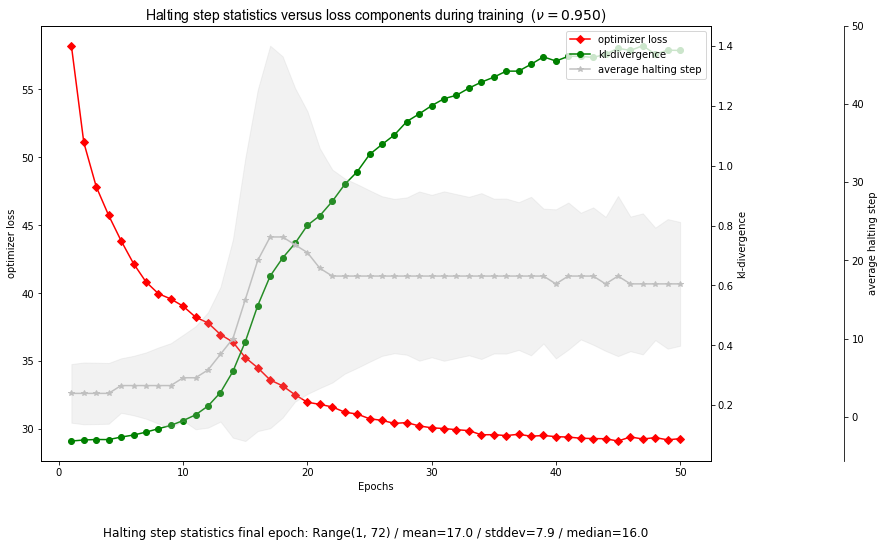

In [13]:
plot_halting_step_stats_with_loss(experiments[2], do_show=True, do_save=False, add_info=True)

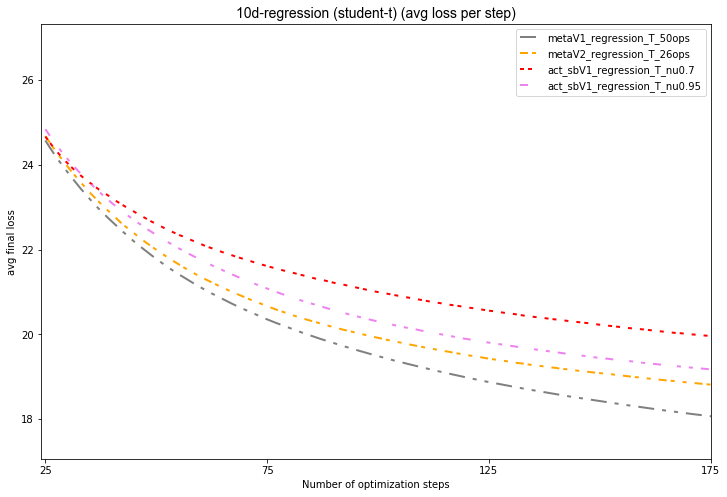

In [28]:
new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[3], new_experiments[4]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_exp_select, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10regT_actsb", 
                                              loss_type="loss",
                                              min_step=25,
                                              max_step=200,
                                              sort_exper="10d-regression (student-t)",
                                              log_scale=False,
                                              with_stddev=False,
                                              runID=None)

In [ ]:
loss_plot(experiments[1], loss_type="opt_loss", save=True, show=True, 
          log_scale=False, validation=True, only_val=False)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [5]:
exp_idx = 4
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps

epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV1_regression_T_nu0.7 with q-prob 0.700


INFO - ! - Validation last step 40 - !
INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 56.32   42.934  38.137  36.298  34.219  32.491  31.327  30.523  29.86
  29.232  28.651  28.168  27.782  27.444  27.123  26.802  26.501  26.227
  25.975  25.752  25.54   25.337  25.15   24.98   24.82   24.669  24.526
  24.392  24.266  24.145  24.039  23.936  23.837  23.748  23.659  23.581
  23.506  23.425  23.359  23.29   23.219  23.146  23.082  23.017  22.959
  22.898  22.835  22.777  22.716  22.66   22.609  22.554  22.5    22.45
  22.403  22.352  22.314  22.264  22.223  22.179  22.134  22.092  22.053
  22.018  21.98   21.939  21.906  21.871  21.835  21.804  21.772  21.738
  21.704  21.672  21.643  21.614  21.584  21.555  21.528  21.503  21.474
  21.451  21.422  21.396  21.372  21.341  21.316  21.295  21.273  21.245
  21.22   21.2    21.181  21.156  21.132  21.11   21.085  21.063  21.041
  21.021  21.     20.981  20.964  20.943  20.924  20.905  20.886  20.869
  20.848  20.827  20.80

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [6]:
print(len(new_experiments))
exp_idx = 0
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV1_regression_T_50ops with 10000 functions


4
Validating model metaV1_regression_T_50ops with q-prob 0.950


INFO - INFO - Epoch 400, elapsed time 8.13 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 4.222e+03/17.79/6.344
INFO - INFO - Epoch 400: Final step losses: [ 56.32   42.141  37.248  35.49   33.774  32.307  31.243  30.487  29.822
  29.205  28.645  28.17   27.774  27.411  27.071  26.757  26.473  26.212
  25.97   25.737  25.516  25.311  25.114  24.927  24.749  24.577  24.412
  24.255  24.106  23.965  23.829  23.695  23.564  23.437  23.315  23.197
  23.082  22.97   22.865  22.763  22.664  22.565  22.469  22.376  22.284
  22.194  22.109  22.025  21.943  21.862  21.784  21.708  21.634  21.561
  21.492  21.425  21.361  21.294  21.232  21.17   21.111  21.05   20.995
  20.942  20.889  20.834  20.782  20.73   20.68   20.63   20.584  20.536
  20.49   20.444  20.4    20.356  20.314  20.273  20.234  20.193  20.155
  20.115  20.077  20.039  20.003  19.967  19.931  19.896  19.863  19.829
  19.797  19.764  19.732  19.7    19.668  19.637

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

In [ ]:
plot_qt_mode_hist(new_experiments[1], do_save=False, do_show=True, add_info=True)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


In [ ]:
plot_qt_detailed_stats(new_experiments[0], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

s = 0.05   # Try s=1, 0.25, 0.1, or 0.05
X = np.arange(-1.2, 4+s, s)   #Could use linspace instead if dividing
Y = np.arange(10, 13+s, s)   #evenly instead of stepping...
    
#Create the mesh grid(s) for all X/Y combos.
X, Y = np.meshgrid(X, Y)

#Rosenbrock function w/ two parameters using numpy Arrays
Z = (3.5-X)**2 + 100.*(Y-X*X)**2

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm,
         linewidth=0, antialiased=False)  #Try coolwarm vs jet

plt.xlabel('x')
plt.ylabel('y')
# ax.zaxis.set_major_locator(LinearLocator(10))
# ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

#Displays the figure, handles user interface, returns when user closes window
plt.show()

In [5]:
"""
    Generate new test functions
"""
test_funcs = RegressionWithStudentT(n_funcs=10000, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
with open("data/test_regression_T_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")


Ready


In [6]:
# test_funcs = RegressionWithStudentT(n_funcs=100, n_samples=10, x_dim=10, scale_p=1., shape_p=1, use_cuda=True)
print(np.array_str(test_funcs.distance_to_min<0))

[False False False ..., False False False]


In [10]:
from utils.regression import nll_with_t_dist

nll_abs_min = nll_with_t_dist(funcs.y_no_noise, funcs.y_t(funcs.true_params), N=10, avg_batch=False)
print(np.array_str(nll_abs_min.data.cpu().squeeze().numpy()))


[ 11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.447299
  11.447299  11.447299  11.447299  11.447299  11.447299  11.44